# Michaelis-Menten Plot from HPLC Analysis

## Curve Fits with Errors Included

We have aliquotes of a stock solution in an enzyme assay. We have five replicates of each enzyme reaction. Below we will calculate the difference between a control and each of the experimental runs. We will get the mean value and standard deviation for the amount of the given diastereomer that is consumed after 3 hours.  I all cases the progress of the reaction is less that 5%.

We will then plot the michaelis-menten plots to determine the enzyme kinetic parameters. We will need to convert to appropriate units for values for $V_{max}$ and $K_M$. I will convert to $\mu M/min$ for $V_{max}$ and $mM$ for $K_M$. I will use the *uncertainties$ package in $Python$ to progate errors so that the final standard deviations can be reported.

This will provide a rigourous and documented source for the $V_{max}$ and $K_M$ values and their standard deviations. You might not agree with my method but you will know exactly what I did.



## Step 1: Load data and calculate means and errors

The code below creates a data frame from the enzyme kinetics experiment and creates a separate data frame for each enzyme (hCE1 and hCE2) as well as the control lanes (C1 and C2).  The difference between the control peak area for PM and each experimental peak area will be calculated. Then a column for the mean and stadard deviation across each row is added. We now have a value for the amount of substrate consumed after 3 hours in terms of peak area.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit

pd.set_option('mode.chained_assignment',None)  ### Supress warnings about "setting with copy" in dataframes


############################
### Set global variables 
############################

#data_path = "https://raw.githubusercontent.com/blinkletter/3530Biochem/main/Permethrin/"
data_path = "./"

image_path = "https://raw.githubusercontent.com/blinkletter/3530Biochem/main/Permethrin/images/"

github_styles_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"

#############################
### Choose data
#############################

file_name = "S-CIS.csv"  ### "R-CIS.csv" or "S-CIS.csv" or "R-TRANS.csv" or "S-TRANS.csv"

################################################################################
### Read data set. The fields are separated by commas; comments are enabled  
################################################################################

df = pd.read_csv(data_path + file_name, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="Vol (/uL)", 
                 comment = "#") 

################################################################################
### Calculate differences for hCE1 and get mean and st_dev
################################################################################

df_hCE1 = df[["hCE1-1", "hCE1-2", "hCE1-3", "hCE1-4", "hCE1-5"]]   # Create dataframe for enzyme #1
start_PM = df["C2"]                                                # Use control lane as initial concentration
df_hCE1 = -df_hCE1.subtract(start_PM, axis='rows')                 # subtract init. conc. from each lane of enzyme #1 results dataframe
                                                                   # This dataframe now has difference in area between start and time point.
means = df_hCE1.mean(axis=1)      # get mean of each row
stdevs = df_hCE1.std(axis=1)      # get stdev of each row

df_hCE1["mean"] = means
df_hCE1["stdev"] = stdevs


################################################################################
### Calculate differences for hCE2 and get mean and st_dev
################################################################################

df_hCE2 = df[["hCE2-1", "hCE2-2", "hCE2-3", "hCE2-4", "hCE2-5"]]    # Create dataframe for enzyme #1
start_PM = df["C2"]                                                 # Use control lane as initial concentration
df_hCE2 = -df_hCE2.subtract(start_PM, axis='rows')                  # subtract init. conc. from each lane of enzyme #1 results dataframe
                                                                    # This dataframe now has difference in area between start and time point.
means = df_hCE2.mean(axis=1)      # get mean of each row
stdevs = df_hCE2.std(axis=1)      # get stdev of each row

df_hCE2["mean"] = means
df_hCE2["stdev"] = stdevs


################################################################################
### Show the dataframes
################################################################################
print("\nThis is the raw data that was read in from the file")
display(df)

print("\nBelow is the peak areas with the 'C2' control (initial concentration) subtracted. \
      \nThese is the five lanes with the CE1 version of the enzyme.")
display(df_hCE1)

print("\nBelow is the peak areas with the 'C2' control (initial concentration) subtracted.  \
      \nThese is the five lanes with the CE2 version of the enzyme.")
display(df_hCE2)


This is the raw data that was read in from the file


,C1,C2,hCE1-1,hCE1-2,hCE1-3,hCE1-4,hCE1-5,hCE2-1,hCE2-2,hCE2-3,hCE2-4,hCE2-5
Vol (/uL),,,,,,,,,,,,
2,111977,108994,104079,103897,107203,107625,105757,105611,104484,104599,102877,102259
5,277785,281063,262401,263053,266434,262604,265124,264293,261267,261035,261614,261516
7,390377,387970,369001,370362,372532,368867,372287,371541,369266,372355,370024,368156
10,557272,558531,530512,533991,533386,529888,531014,534361,531448,531491,535866,532352
30,1672202,1671218,1623730,1621399,1623681,1622875,1621065,1636445,1636464,1633738,1638858,1635164
50,2784245,2787453,2726625,2724999,2727832,2722879,2726229,2744340,2745959,2745358,2746406,2747136
100,5572945,5570797,5497669,5496082,5500820,5498028,5497174,5529947,5529167,5529675,5530672,5529079



Below is the peak areas with the 'C2' control (initial concentration) subtracted.       
These is the five lanes with the CE1 version of the enzyme.


,hCE1-1,hCE1-2,hCE1-3,hCE1-4,hCE1-5,mean,stdev
Vol (/uL),,,,,,,
2,4915,5097,1791,1369,3237,3281.8,1720.871059
5,18662,18010,14629,18459,15939,17139.8,1772.051551
7,18969,17608,15438,19103,15683,17360.2,1746.056041
10,28019,24540,25145,28643,27517,26772.8,1819.314761
30,47488,49819,47537,48343,50153,48668.0,1255.708167
50,60828,62454,59621,64574,61224,61740.2,1879.462210
100,73128,74715,69977,72769,73623,72842.4,1761.635547



Below is the peak areas with the 'C2' control (initial concentration) subtracted.        
These is the five lanes with the CE2 version of the enzyme.


,hCE2-1,hCE2-2,hCE2-3,hCE2-4,hCE2-5,mean,stdev
Vol (/uL),,,,,,,
2,3383,4510,4395,6117,6735,5028.0,1367.004755
5,16770,19796,20028,19449,19547,19118.0,1331.774193
7,16429,18704,15615,17946,19814,17701.6,1695.595854
10,24170,27083,27040,22665,26179,25427.4,1944.112985
30,34773,34754,37480,32360,36054,35084.2,1891.263652
50,43113,41494,42095,41047,40317,41613.2,1060.242519
100,40850,41630,41122,40125,41718,41089.0,647.268878


## Step 2: Perform curve fit with errors

The code below perform a curve fit that includes the errors in each data point (using the standard deviations as the errors). A slope with a standard deviation will be obtained.

I fit the data to the following linear relationship: $$ y = V_{max}\frac{x}{x + K_M} $$ where $y$ is the area, $x$ is the volume of stock solution in each experiment and $y$ is the area difference after 3 hours.  

In [2]:
################################################################################
### Assign arrays of data to x, y, and standard deviations
################################################################################

x = df_hCE1.index
y = df_hCE1["mean"]
stdev = df_hCE1["stdev"]

################################################################################
### Linear curve fit on the collected x,y data
################################################################################

### Create functions that describe linear line fits

def MM_fit(x, Vmax, KM):
    return Vmax * x / (x + KM)


### Perform curve fit using function of choice. Use 'linear' or 'linear0'

param, pcov = curve_fit(MM_fit,              ### use 'linear' or 'linear0'
                        x, y,                ### The day for the fit
                        sigma = stdev,       ### Array of errors for each data point
                        absolute_sigma=True, ### Errors are values, not factors.
                        bounds=([0, 0],[np.inf, np.inf])
                        )

perr = np.sqrt(np.diag(pcov))  ### Calculate st_devs for line fit from covariance matrix


### Use with 'linear0' curve fit. 

Vmax1, KM1 = param             ### param is an array. Vmax is first item and KM is the second.
Vmax1_stdev, KM1_stdev = perr  

#print(f"Line is y = ({slope:0.2f} +/- {slope_stdev:0.2f})x")
print(Vmax1,Vmax1_stdev)
print(KM1,KM1_stdev)

print(x)
print(y)

92782.8318166578 3368.861993951713
26.651339592485705 2.3734667101876306
Int64Index([2, 5, 7, 10, 30, 50, 100], dtype='int64', name='Vol (/uL)')
Vol (/uL)
2       3281.8
5      17139.8
7      17360.2
10     26772.8
30     48668.0
50     61740.2
100    72842.4
Name: mean, dtype: float64


## Step 3: Plot data with error pars and line fit

The code below will plot the mean area for the peak area differences in our five experiments (with error bars) against the stock solution volume.  The error bars are created using the standard deviations for each mean. A Michaelis-Menten is plotted using the curve fit data.

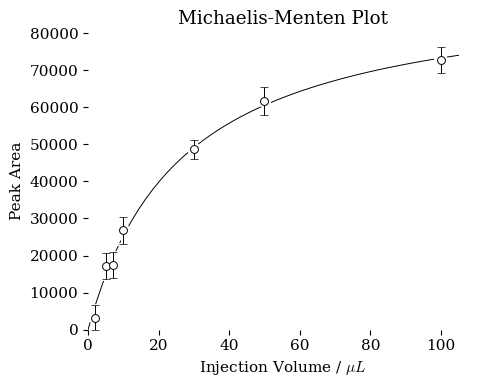

Vmax is (92782.83 +/- 3368.86) Area units/3 hours
KM is (26.65 +/- 2.37) uL injection volume


In [3]:
##################################################
### Setup a figure and choose a style for plot
##################################################

plt.style.use(github_styles_location + "tufte.mplstyle")        
#plt.style.use(github_styles_location + "S2_classic2.mplstyle")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

########################
### Plot the data    ###
########################

### Plot data points

ax.scatter(x,y, marker = "o", color = "white", s = 96, edgecolors = "none", linewidths=0.7, zorder = 1)
ax.scatter(x,y, marker = "o", color = "white", s = 32, edgecolors = "black", linewidths=0.7, zorder = 3)


### Add error bars (command could be all on one line as above, but is separated for adding comments)

ax.errorbar(x, y,             ### data
            yerr = 2*stdev, ### y errors
            xerr = None,      ### x errors
            fmt = 'None',     ### Data marker style
            ecolor = "white", ### Color of error bars
            elinewidth = 3, ### Thickness of vertical bar
            capsize = 4,      ### width of cap (in points)
            capthick = 2,   ### thickness of cap line
            zorder = 2)
ax.errorbar(x, y,             ### data
            yerr = 2*stdev, ### y errors
            xerr = None,      ### x errors
            fmt = 'None',     ### Data marker style
            ecolor = "black", ### Color of error bars
            elinewidth = 0.7, ### Thickness of vertical bar
            capsize = 3,      ### width of cap (in points)
            capthick = 0.5,   ### thickness of cap line
            zorder = 2)


last_x = np.max(df.index)     ### Convert row index into array and choose largest value
x_axis = np.linspace([0, last_x * 1.05], 100)  ### Create x-axis for ploting caluclated line fit


### Plot calculated line

ax.plot(x_axis, MM_fit(x_axis, Vmax1, KM1),    ### x, y calculated data for line
        "-", color = "black",      ### solid black line
        linewidth=0.7, zorder = 0  ### line thickness and layer (0 is farthest back)
        )


############################
### Set labels and scale 
############################

ax.set(title = "Michaelis-Menten Plot",
        ylabel=r"Peak Area", 
        xlabel=r"Injection Volume / $\mu L$",
        xlim=0,
        ylim=0
      )

ax.margins(x=.07, y=.07, tight=True)    # add 7% empty space around outside of plot area   

#############################
### Output the final plot 
#############################

fig.savefig("plot_hCE1.pdf")   ### use this to save the figure in PDF format
plt.show()                ### output the combined plot plots

print(f"Vmax is ({Vmax1:0.2f} +/- {Vmax1_stdev:0.2f}) Area units/3 hours")
print(f"KM is ({KM1:0.2f} +/- {KM1_stdev:0.2f}) uL injection volume")



## Steps 4 and 5: Do It All Again with hCE2

In [4]:
################################################################################
### Assign arrays of data to x, y, and standard deviations
################################################################################

x = df_hCE2.index
y = df_hCE2["mean"]
stdev = df_hCE2["stdev"]

################################################################################
### Linear curve fit on the collected x,y data
################################################################################

### Create functions that describe linear line fits

def MM_fit(x, Vmax, KM):
    return Vmax*x/(x+KM)


### Perform curve fit using function of choice. Use 'linear' or 'linear0'

param, pcov = curve_fit(MM_fit,              ### use 'linear' or 'linear0'
                        x, y,                ### The day for the fit
                        sigma = stdev,       ### Array of errors for each data point
                        absolute_sigma=True, ### Errors are values, not factors.
                        bounds=([0, 0],[np.inf, np.inf])
                        )

perr = np.sqrt(np.diag(pcov))  ### Calculate st_devs for line fit from covariance matrix


### Use with 'linear0' curve fit. 

Vmax2, KM2 = param             ### param is an array. Vmax is first item and KM is the second.
Vmax2_stdev, KM2_stdev = perr  

print(Vmax2,Vmax2_stdev)
print(KM2,KM2_stdev)


45565.797544615394 823.3985326575346
8.631090938764096 0.8044860511691818


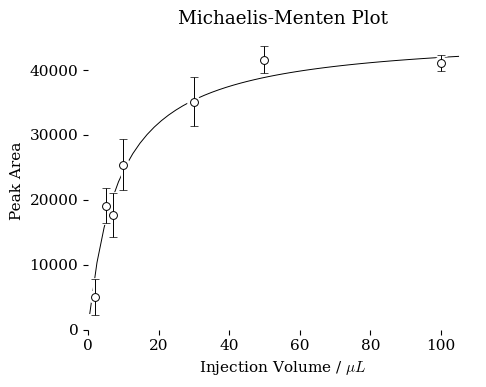

Vmax is (45565.80 +/- 823.40) Area units/3 hours
KM is (8.63 +/- 0.80) uL injection volume


In [5]:
##################################################
### Setup a figure and choose a style for plot
##################################################

plt.style.use(github_styles_location + "tufte.mplstyle")        
#plt.style.use(github_styles_location + "S2_classic2.mplstyle")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

########################
### Plot the data    ###
########################

### Plot data points

ax.scatter(x,y, marker = "o", color = "white", s = 96, edgecolors = "none", linewidths=0.7, zorder = 1)
ax.scatter(x,y, marker = "o", color = "white", s = 32, edgecolors = "black", linewidths=0.7, zorder = 3)


### Add error bars (command could be all on one line as above, but is separated for adding comments)

ax.errorbar(x, y,             ### data
            yerr = 2*stdev, ### y errors
            xerr = None,      ### x errors
            fmt = 'None',     ### Data marker style
            ecolor = "white", ### Color of error bars
            elinewidth = 3, ### Thickness of vertical bar
            capsize = 4,      ### width of cap (in points)
            capthick = 2,   ### thickness of cap line
            zorder = 2)
ax.errorbar(x, y,             ### data
            yerr = 2*stdev, ### y errors
            xerr = None,      ### x errors
            fmt = 'None',     ### Data marker style
            ecolor = "black", ### Color of error bars
            elinewidth = 0.7, ### Thickness of vertical bar
            capsize = 3,      ### width of cap (in points)
            capthick = 0.5,   ### thickness of cap line
            zorder = 2)


last_x = np.max(df.index)     ### Convert row index into array and choose largest value
x_axis = np.linspace([0.5, last_x * 1.05], 100)  ### Create x-axis for ploting caluclated line fit


### Plot calculated line

ax.plot(x_axis, MM_fit(x_axis, Vmax2, KM2),    ### x, y calculated data for line
        "-", color = "black",      ### solid black line
        linewidth=0.7, zorder = 0  ### line thickness and layer (0 is farthest back)
        )


############################
### Set labels and scale 
############################

ax.set(title = "Michaelis-Menten Plot",
        ylabel=r"Peak Area", 
        xlabel=r"Injection Volume / $\mu L$",
        xlim=0,
        ylim=0
      )

ax.margins(x=.07, y=.07, tight=True)    # add 7% empty space around outside of plot area   

#############################
### Output the final plot 
#############################

fig.savefig("plot_hCE2.pdf")   ### use this to save the figure in PDF format
plt.show()                ### output the combined plot plots

print(f"Vmax is ({Vmax2:0.2f} +/- {Vmax2_stdev:0.2f}) Area units/3 hours")
print(f"KM is ({KM2:0.2f} +/- {KM2_stdev:0.2f}) uL injection volume")


### Step 4: Convert to preferred units and track errors

The code below will use the *uncertainties* package in the *Python* library to perform calculations with error propagation. We won't have to know how to propagate errors correctly but anyone examining my work will be able to see exactly what I did. 

The *uncertainties* package is not included in the *Python* standard library and so must be installed using the code cell below. Only run this cell once. It wont hurt if you run it again; it just wastes time.

The code cell underneath the install code will import our slope and standard deviation from the line fit and create a ufloat object.  This is a number that includes the uncertainty. Observe the ways I printed it out.

In [6]:
####################################
### Install UNCERTAINTIES package 
####################################

#%pip install uncertainties

#### Notes on Errors

We now can state the other values. We dont have a population of measurements to determine the standard deviations for these values, we just have "estimated errors" based on experience and manufacturer information.

The automatic sample **injector** is reported to have an accuracy of $\pm 0.1 \, \mu L$

When **weighing** the permethrin sample I used a **balance** with an accuracy of $\pm 0.1 \, mg$

The **pipette** that I used to transfer the solvent for the sample solution has an accuracy of $\pm 0.01 \, mL$

The **pipette** that I used to transfer the stock solution to each sample has an accuracy of $\pm 0.001 \, mL$

Observe the features of the *uncertanties* package that I used to create these ufloat values.

In [7]:
import uncertainties as un
from uncertainties import unumpy as unp
from uncertainties import umath as um


####################################################################################
### Create calibration coefficient as a floating point number with uncertainty
####################################################################################

coeff = un.ufloat_fromstr("640.09+/-32.18")   # Area / umole in sample.

##################################
### Print out the ufloat value
##################################

print(f"The calibration coefficient is {coeff:0.2f} per microlitre")


The calibration coefficient is 640.09+/-32.18 per microlitre


### Converting Initial Area to Concentration

The C2 control series is used to define the initial concentration. It is a tube where no enzyme was present during the time of the reaction. We have previously measured that hydrolysis at pH 7.0 is insignificant over the time frame of 3 hours. The amount of one particular diastereomer will be some fraction of the total permethrin concentration.  The orrelation coefficient was calculated fro the total permethrin concentration. (In hindsite I should have treated each of the four peaks separately rather than combining them. The data is still on the computer of the HPLC; perhaps I should go back and recalculate?)

Rather than dig up my old data, I will move forward with the calibration coefficient and the measured areas in this experiment to determine a new factor that will convert the volume of the permethrin aliquote to concentration in the reaction sample.

First we note the concentration of the stock solution.  It is 2 g in 1 mL DMSO. that is a high concentration, but it needs to be high so that a minumum amount of DMSO solution is added in each experimental sample. Enzymes prefer water and we want to use the minimum amount of DMSO cosolvent.

We can calculate the expected concentration of total eprmethrin in each tube and plot it against the measured amount of the given diastereomer (using the calibration coefficient and the area for the diastereomer peak). The slope of the line will define this factor.

In [8]:
volume_stock = un.ufloat_fromstr("1+/-0.01")    ### volume of stock solution is 2 mL; creating ufloat from text
mass = un.ufloat(2,0.0001)                   ### mass is 2 g; creating ufloat from list
molar_mass = 391.29                       ### molar mass of permethrin is 391.29 g/mole; no uncertainty here
volume_reaction = un.ufloat_fromstr("1+/-0.010")
injection_volume = un.ufloat_fromstr("0.100+/-0.0001")


conc_stock_soln = (mass / molar_mass) / (volume_stock * (1/1000))

print(f"Concentration of stock solution is {conc_stock_soln:0.2f}")

aliquotes = unp.uarray(df.index, 0.1)   ### uL injected into each 1 mL reaction vessel
conc_pm_reaction = (aliquotes/1000) * conc_stock_soln / (volume_reaction/1000)
#print(aliquotes)

#print("\n uarray for concentrations of total PM in experiment wells")
#print(conc_pm_reaction)

print("\n Calculated Expected Total Area for all Permethrins")
moles_injected = conc_pm_reaction * (injection_volume/1000)
expected_total_area = moles_injected * coeff * 1000000 
print(expected_total_area)

print("\n Observed Area for a chosen diastereomer")
observed_area_this_diastereomer = df["C2"]
print(observed_area_this_diastereomer)



Concentration of stock solution is 5.11+/-0.05

 Calculated Expected Total Area for all Permethrins
[654338.2146234252+/-47314.10856215783
 1635845.536558563+/-91497.67827952169
 2290183.751181988+/-124020.95330219094
 3271691.073117126+/-174000.32120314354
 9815073.219351375+/-513733.23430243705
 16358455.36558563+/-855110.1008191485
 32716910.73117126+/-1709281.1206318177]

 Observed Area for a chosen diastereomer
Vol (/uL)
2       108994
5       281063
7       387970
10      558531
30     1671218
50     2787453
100    5570797
Name: C2, dtype: int64


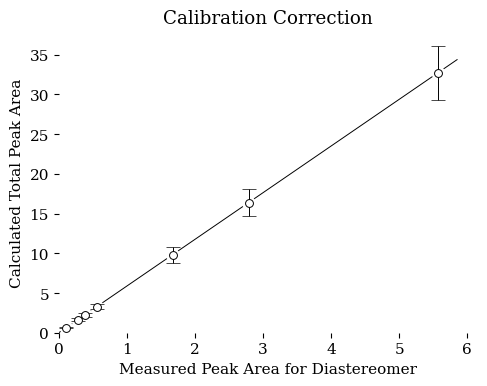

Line is y = (5.88 +/- 0.12)x
5.88+/-0.12
Calibration factor: 0.170+/-0.004


In [9]:
################################################################################
### Assign arrays of data to x, y, and standard deviations
################################################################################

x = observed_area_this_diastereomer/1e6
y = unp.nominal_values(expected_total_area)/1e6
stdev = unp.std_devs(expected_total_area)/1e6

################################################################################
### Linear curve fit on the collected x,y data
################################################################################

### Create functions that describe linear line fits

def linear(x, slope, intercept):
    return slope * x + intercept

def linear0(x, slope):
    return slope * x 

### Perform curve fit using function of choice. Use 'linear' or 'linear0'

param, pcov = curve_fit(linear0,             ### use 'linear' or 'linear0'
                        x, y,                ### The day for the fit
                        sigma = stdev,       ### Array of errors for each data point
                        absolute_sigma=True  ### Errors are values, not factors.
                        )

perr = np.sqrt(np.diag(pcov))  ### Calculate st_devs for line fit from covariance matrix


### Use with 'linear0' curve fit. 

slope = param[0]       ### param is an array and slope is the first (or only) entry
slope_stdev = perr[0]  ### param is an array and slope is the first (or only) entry

#print(f"Line is y = ({slope:0.2f} +/- {slope_stdev:0.2f})x")

##################################################
### Setup a figure and choose a style for plot
##################################################

plt.style.use(github_styles_location + "tufte.mplstyle")        
#plt.style.use(github_styles_location + "S2_classic2.mplstyle")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

########################
### Plot the data    ###
########################

### Plot data points

ax.scatter(x,y, marker = "o", color = "white", s = 96, edgecolors = "none", linewidths=0.7, zorder = 1)
ax.scatter(x,y, marker = "o", color = "white", s = 32, edgecolors = "black", linewidths=0.7, zorder = 3)


### Add error bars (command could be all on one line as above, but is separated for adding comments)

ax.errorbar(x, y,             ### data
            yerr = 2 * stdev, ### y errors
            xerr = None,      ### x errors
            fmt = 'None',     ### Data marker style
            ecolor = "black", ### Color of error bars
            elinewidth = 0.7, ### Thickness of vertical bar
            capsize = 5,      ### width of cap (in points)
            capthick = 0.5,   ### thickness of cap line
            zorder = 2)


last_x = np.max(x)     ### Convert row index into array and choose largest value
x_axis = np.linspace(0, last_x * 1.05, 100)  ### Create x-axis for ploting caluclated line fit

### Plot calculated line

ax.plot(x_axis, x_axis * (slope),    ### x, y calculated data for line
        "-", color = "black",      ### solid black line
        linewidth=0.7, zorder = 0  ### line thickness and layer (0 is farthest back)
        )


############################
### Set labels and scale 
############################

ax.set(title = "Calibration Correction",
        ylabel=r"Calculated Total Peak Area", 
        xlabel=r"Measured Peak Area for Diastereomer",
        xlim=0,
        ylim=0
      )

ax.margins(x=.07, y=.07, tight=True)    # add 7% empty space around outside of plot area   

#############################
### Output the final plot 
#############################

fig.savefig("plot.pdf")   ### use this to save the figure in PDF format
plt.show()                ### output the combined plot plots

print(f"Line is y = ({slope:0.2f} +/- {slope_stdev:0.2f})x")

line_slope = un.ufloat(slope,slope_stdev)
calibration_factor = 1/line_slope
print(line_slope)
print(f"Calibration factor: {calibration_factor:0.3f}")



The calibration factor shows that this diastereomer is a certain fraction of the total population of permethrins.  For example, if the factor was $0.28$ then that given diastereomer is $28\%$ of the total permethrin and the concentration of that disatereomer would be scaled accordingly.

We could have just used the ratio of the expected total peak area to the measured peak area of a disatereomer to get this factor but I chose to use a line fit which gives me the same result and but also serves to include all the experimental initial diastereomer peak areas. The curve fit function will report a standard deviation for the line fit that will be the error for this concentration adjustment factor.

There are other ways to to this.  I could have calculated the factor for each tube in the control lane and then averaged them to get mean and the standard deviation. either method is acceptable. the key point is that the approach I used above is documented. No matter how bad my explanation of what I did is, the *Python* code describes exactly what was done. 

feel free to criticize my work. You can see what I did and make it better.

### Calculating Parameters

We have values for $V_{max}$ and $K_M$ for this disatereomer of permethrin with each of the two versions of *carboxyesterase*. The values are expressed in terms of how much of the permethrin stock solution is in each tube and the amount that the peak area was reduced after 3 hours. We can convert these values to more common concentration and rate units.

Examine the code below.  I am again using the *uncertainties* package to track error propagation.

In [10]:
KM1_mM = un.ufloat(KM1,KM1_stdev)


### KM = uL injected in reaction. Convert to mM.
### KM = uL * 1 L/10^6 uL * mol/L * 1/mL * 1000mL/L * n

KM1_mM = (KM1_mM/1000000) * conc_stock_soln * 1/volume_reaction * 1000 * calibration_factor
print(f"For hCE1: KM = {KM1_mM:0.4f} mM")

KM2_mM = un.ufloat(KM2,KM2_stdev)

KM2_mM = (KM2_mM/1000000) * conc_stock_soln * 1/volume_reaction * 1000 * calibration_factor
print(f"For hCE2: KM = {KM2_mM:0.4f} mM")

### Vmax is in dArea/3 hours.  Convert to umoles/L.min
### Vmax = Area/3hr *1hr/60min * 1umole/640.09+/-32.18 Area * 1/0.0001 L

Vmax1_uMmin = un.ufloat(Vmax1,Vmax1_stdev)
Vmax1_uMmin = Vmax1_uMmin/360/coeff/0.0001
print(f"For hCE1: Vmax = {Vmax1_uMmin:0.4f} uM/min")

Vmax2_uMmin = un.ufloat(Vmax2,Vmax2_stdev)
Vmax2_uMmin = Vmax2_uMmin/360/coeff/0.0001
print(f"For hCE1: Vmax = {Vmax2_uMmin:0.4f} uM/min")

Mol_Wt_Enz = 61800 # g/mole
Enz_Specific_Activity = 58000 # units/mg
Enz_Units = un.ufloat(10000,100) #  10000 +/- 100 units
Volume_Enz_Solution = un.ufloat(1000,10) # 1000 +/- 10 uL
Aliquote_Enz = un.ufloat(50,0.1)  # 50 +/- 0.1 uL

mass_enz = Enz_Units / Enz_Specific_Activity
moles_enz = mass_enz / Mol_Wt_Enz /1000
conc_Enz_Solution = moles_enz / (Volume_Enz_Solution * 1/1000000) ### 1L/1000000uL
Enz_Conc = conc_Enz_Solution * (Aliquote_Enz/1000000) / (volume_reaction/1000)
print(f"[E] = {Enz_Conc}")
kcat1 = (Vmax1_uMmin/1000000/60) / Enz_Conc
print(f"For hCE1: kcat = {kcat1:0.4g} /s")
kcat2 = (Vmax2_uMmin/1000000/60) / Enz_Conc
print(f"For hCE2: kcat = {kcat2:0.4f} /s")

print(f"For hCE1: kcat/KM = {kcat1/(KM1_mM/1000):0.4f} /s")
print(f"For hCE2: kcat/KM = {kcat2/(KM3_mM/1000):0.4f} /s")

print()
print(kcat1/(KM1_mM/1000))
print(volume_reaction)

For hCE1: KM = 0.0232+/-0.0021 mM
For hCE2: KM = 0.0075+/-0.0007 mM
For hCE1: Vmax = 4026.4664+/-249.7008 uM/min
For hCE1: Vmax = 1977.4041+/-105.6392 uM/min
[E] = (1.395+/-0.024)e-07
For hCE1: kcat = 481.1+/-31.0 /s
For hCE2: kcat = 236.2602+/-13.2770 /s
For hCE1: kcat/KM = 20755918.0156+/-2358801.2620 /s


NameError: name 'KM3_mM' is not defined

## Rinse and Repeat

There are four data sets, one for each peak in the HPLC chromatogram. We can alayze all four using this notebook. We can report the exact methiods used in data analysis by providing this notebook as the documentation. the code reveals what we did in precise detail. The truth is there for all to criticize or marvel.